# BlocQto - The 2 player Strategy Game for built for a Quantum Computer



If you're reading this, the intrigue you had when you clicked our Medium article has grown into interest, and for that, we are happy. Through this Jupyter notebook, we will understand the mechanics (or quantum mechanics?) of the game and then actually play the game. So let's get started.

## Installing and Importing Packages



We install Qiskit, the open source software development libraries in python by IBM. The game is written completely in python and extensively uses Qiskit. This is useful to run the game in an actual quantum computer.


In [0]:
#Uncomment the following line to install qiskit if you haven't already.
#pip install qiskit

In [0]:
from qiskit import *
import numpy as np
import math
from qiskit.visualization import plot_histogram
import matplotlib as mpl
import operator
import pandas as pd
from random import choices, seed
from itertools import permutations
import random
from IPython.display import display, HTML
import getpass

## The Physics and Mathematics of BlocQto



We first give a brief introduction to and explanation of the game mechanics. A more detailed explanation of the math and physics of the game is available in the accompanying Medium articles.

The game is designed to be played for six rounds divided into two halves of 3 rounds each. The mechanics of each round is the same, except for the differences in results caused by the strategies adopted by the players. Throughout this notebook, we will refer to Player 1 as Alice and Player 2 as Bob. 

The game as a whole is played as follows:

1.   Alice and Bob enter four troop configurations (which are just 6 numbers, real or imaginary, but not complex) each for the first half of three rounds.
2. Rounds 1 is played, where both Alice and Bob picks one out of their entered configuration, and then pick an island each as their control qubits for entanglement. Round mechanics, which will be explained shortly, are conducted. Scores and other relavant statistics are displayed.
3. Round 2 and 3 are played out similarly. 
4. First half has ended. Players enter four more troop configurations each for the next three rounds. The one remaining pair of configurations is discarded.
5. Round 4, 5, 6 are played out.
6. The player with higher score, which is the cumulative scores of all the rounds, is the winner.

This is the overall structure of the game. We now explain the mechanics of a single round.

A single round consists of the following steps:
1. Quantum state preparation through application of rotation gates. 
2. Transformation of states to simulate measurement on a different basis.
3. Application of CNOT gates to entangle qubits.
4. Measure the qubits and display the results.

Each of the above step have mathematics and physics behind it which we will now explain briefly. Detailed explanations are available in the accompanying articles.

### Quantum State Preparation
The input each round is the troop configuration by Alice and Bob. Let us call one pair of such configuration $C_A$ and $C_B$. where $C_A = [a_i]_{i=1}^6$ and $C_B = [b_i]_{i=1}^6$. Let each island, which corresponds to  single qubit, represented by a state vector $|\psi_i\rangle$. Through state preparation, we would like to take each qubit from $|0\rangle$ to $|\psi_i\rangle$ which is defined as $\alpha_i|0\rangle + \beta_i|1\rangle$ where

$$|\psi_i\rangle = \begin{bmatrix}\alpha_i \\ \beta_i\end{bmatrix} = \frac{1}{\sqrt{a_i^2 + b_i^2}} \begin{bmatrix}a_i \\ b_i\end{bmatrix}$$

We see that $|\psi_i\rangle$ are simply the normalised representation of the troops in each island. By the rules of the game, $a_i,b_i$ can only be purely imaginary or purely real, hence so will be $\alpha_i$ and $\beta_i$.

We must now construct transformations $R_i$ for each island such that $$R_i|0\rangle = |\psi_i\rangle$$
as the qubits are always initialised in $|0\rangle$.

This is done through the $R_y$ and  $R_z$ gates which are standard single qubit gates of the form
$$R_y(\theta) = \begin{bmatrix} cos\frac{\theta}{2} & -sin\frac{\theta}{2} \\ sin\frac{\theta}{2}& cos\frac{\theta}{2} \end{bmatrix} \hspace{5pt} R_z(\theta) = \begin{bmatrix} e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2} \end{bmatrix}$$

We construct 
$$R_i \equiv R(\theta_i,\phi_i) = R_z(\phi_i)R_y(\theta_i)$$
where $$\phi_i = \arcsin\bigg(\frac{\text{Im}(\beta_i)}{|\beta_i|}\bigg) - \arcsin\bigg(\frac{\text{Im}(\alpha_i)}{|\alpha_i|}\bigg)$$ and $$\theta_i = 2*\arctan\bigg(\frac{e^{-i\phi_i}\beta_i}{ \alpha_i}\bigg)$$

We now apply each of the $R_i$ gates to the corresponding qubits (except those who are the target qubits for entanglement, but more on that later) to take them to $|\psi_i\rangle$. 


### Change of Basis Transformation
In Qiksit, all measurements are carried out in the standard $z$-eigenbasis $ = \{|0\rangle \equiv |+z\rangle,|1\rangle \equiv |-z\rangle\}$ where $$|0\rangle = \begin{bmatrix}0 \\ 1\end{bmatrix},  |1\rangle = \begin{bmatrix}1 \\ 0\end{bmatrix}$$

A core element of BlocQto gameplay is that each island is measured in different basis, and hence the same configuration, say $a_i,b_i$, will give vastly different results on different islands. Apart from the $z$ eigenbasis, we choose to measure on $x$ and $y$ eigenbases. These correspond to three of the six islands. In the other three islands, we first apply an $X$ gate to the state, hence switching the amplitudes (and hence probabilities) associated with $|0\rangle$ and $|1\rangle$. Such *switched* bases are denoted with an overhead line. 

The six bases in which states are measured in BlocQto are $[Z, \overline{Z}, X, \overline{X}, Y, \overline{Y}]$. It might be a good idea to list them and their eigenvectors. 

$$X = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix},\hspace{10pt} |+x\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ 1\end{bmatrix}, \hspace{5pt}|-x\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ -1\end{bmatrix}$$ 

$$Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, \hspace{10pt} |+y\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ i\end{bmatrix}, \hspace{5pt}|-y\rangle = \frac{1}{\sqrt{2}}\begin{bmatrix}1 \\ -i\end{bmatrix}$$ 

$$Z = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},\hspace{10pt} |+z\rangle = \begin{bmatrix}1 \\ 0\end{bmatrix},\hspace{5pt}|-z\rangle = \begin{bmatrix}0 \\ 1\end{bmatrix}$$

The idea behind change of basis transformation is that since we cannot measure $|\psi\rangle$ in $x$ and $y$ eigenbasis, we would like to transform $|\psi\rangle$ into $|\phi\rangle = T_x^\dagger|\psi\rangle$ such that measuring $|\phi\rangle$ in $z$ eigenbasis - the standard basis - is the same as measuring $|\psi\rangle$ in $x$ eigenbasis. Mathematically, we need to find transformation $T_x$ such that $$ \langle\psi|P_{0}^{x}|\psi\rangle = \langle\phi|P_{0}|\phi\rangle=\langle\psi| T_x P_{0} T_x^\dagger|\psi\rangle$$
$$ \langle\psi|P_{1}^{x}|\psi\rangle = \langle\phi|P_{1}|\phi\rangle=\langle\psi| T_x P_{1} T_x^\dagger|\psi\rangle$$

with similar results holding for measurement in $y$ eigenbasis as well. Here 

$$P_0 = P_0^z = |0\rangle\langle0| \hspace{10pt} P_1 =P_1^z = |1\rangle\langle1|$$

$$P_0^x = |+x\rangle\langle+x| \hspace{10pt} P_1^x = |-x\rangle\langle-x|$$

$$P_0^y = |+y\rangle\langle+y| \hspace{10pt} P_1^y = |-y\rangle\langle-y|$$


Take a look at this table for a quick overview on the six bases, how we transform the statevector to emulate measurement on the correspoding basis and the probabilities associated with Alice and Bob winning the island. Note that the math has been done for a single qubit.

$$\begin{matrix} \text{Basis} & \text{Statevector}  & P_{Alice} & P_{Bob} \\ 
Z & |\psi\rangle = \alpha|0\rangle + \beta|1\rangle & |\alpha|^2 & |\beta|^2 \\
\overline{Z} & X|\psi\rangle = \beta|0\rangle + \alpha|1\rangle & |\beta|^2 & |\alpha|^2 \\
X & T_x^\dagger|\psi\rangle = \frac{\alpha + \beta}{\sqrt{2}}|0\rangle + \frac{\alpha - \beta}{\sqrt{2}}|1\rangle &  \frac{|\alpha + \beta|^2}{2} & \frac{|\alpha - \beta|^2}{2} \\
\overline{X} & XT_x^\dagger|\psi\rangle = \frac{\alpha - \beta}{\sqrt{2}}|0\rangle + \frac{\alpha + \beta}{\sqrt{2}}|1\rangle &  \frac{|\alpha - \beta|^2}{2} & \frac{|\alpha + \beta|^2}{2} \\
Y & T_y^\dagger|\psi\rangle = \frac{\alpha + i \beta}{\sqrt{2}}|0\rangle + \frac{\alpha - i\beta}{\sqrt{2}}|1\rangle &  \frac{|\alpha + i \beta|^2}{2} & \frac{|\alpha - i \beta|^2}{2} \\
\overline{Y} & XT_y^\dagger|\psi\rangle = \frac{\alpha - i\beta}{\sqrt{2}}|0\rangle + \frac{\alpha + i\beta}{\sqrt{2}}|1\rangle &  \frac{|\alpha - i \beta|^2}{2} & \frac{|\alpha + i \beta|^2}{2} \\
\end{matrix}$$


$T_x^\dagger$ and $T_y^\dagger$ are the transformation operators, which form the operational part of this section. They are the complex conjugate of $T_x$ and $T_y$ matrices, constructed from the eigenvectors of $X$ and $Y$ as follows:

$$T_x = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1\\ 1 & -1\end{bmatrix} \hspace{5pt} T_y = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1\\ i & -i\end{bmatrix}$$

We see that $T_x = T_x^\dagger$ is the same as Hadamard gate $H$, an important single qubit gate which is available in Qiskit by default. For constructing $T_y^\dagger$ we make use of the $U_3(\theta,\phi,\lambda)$ gate available in Qiskit, which is given by

$$U_3(\theta,\phi,\lambda) = \begin{bmatrix} \cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2})\\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i(\lambda+\phi)}\cos(\frac{\theta}{2})\end{bmatrix}$$

On setting $(\theta = -\frac{\pi}{2} ,\phi = -\pi,\lambda = -\frac{\pi}{2})$, we obtain 
$$U_3(-\frac{\pi}{2},-\pi,-\frac{\pi}{2}) = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & -i\\ 1 & i\end{bmatrix} = T_y^\dagger$$

Using $T_x^\dagger$ or $T_y^\dagger$, we transform $|\psi\rangle$ to obtain the result of measuring it in $X$ or $Y$ basis. To simulate measurement in $\overline{X}$ or $\overline{Y}$ basis, we further pass the transformed state through an $X$ gate. 

This is how we perform the change of basis transformation in BlocQto. Once you crack the island - basis mapping, you have essentially won, as now you know how to position your troops on each basis.

### Incorporating Entanglement

By adding entanglement, we introduce another layer of intricacy to the game without making it too complicated. At the beginning of each round, both Alice and Bob pick an island (qubit) each as their control qubit, say $c_A$ and $c_B$ and is made public. $c_A$ must be different from $c_B$, and Alice and Bob will alternate to pick control qubits first. The game then randomly chooses 2 out of the remaining 4 islands as target qubits, say $t_A$ and $t_B$. The identity of the target qubits are not disclosed.

For the first five rounds, players cannot pick an island as control qubit if they have already picked it in a previous round. In the sixth and final round, players have no such restriction based on their history. The only restriction, like in every other round, is that both Alice and Bob cannot pick the same island as control.

The aim of this process is to entangle the results of target islands and control islands. If Alice were to win in $c_A$ (or $c_B$), then Alice would also win in $t_A$ (or $t_B$) regardless of how well Bob had 'positioned' his troops on the island $t_B$. 

To achieve this, we do not perform the above two steps on the target qubits. i.e., we neither perform the rotation for state preparation nor perform the change of basis transformation. We only implement $CNOT$ gates between $c_A$  & $t_A$ and $c_B$ & $t_B$ seperately with $c_A,c_B$ being control qubits and $t_A,t_B$ being target qubits. This can be mathematically shown as (for 2 qubits):
$$\begin{matrix}
|0\rangle_\text{con}|0\rangle_\text{tar}  & \xrightarrow{R(\theta,\phi)\otimes \mathbb{I}} & |\psi\rangle_\text{con}|0\rangle_\text{tar} = (\alpha|0\rangle_\text{con}+ \beta|1\rangle_\text{con})|0\rangle_\text{tar} \\ 
|\psi\rangle_\text{con}|0\rangle_\text{tar} & \xrightarrow{T^\dagger\otimes \mathbb{I}} & |\phi\rangle_\text{con}|0\rangle_\text{tar} = (\alpha'|0\rangle_\text{con}+ \beta'|1\rangle_\text{con})|0\rangle_\text{tar} \\
(\alpha'|0\rangle_\text{con}+ \beta'|1\rangle_\text{con})|0\rangle_\text{tar} 
& \xrightarrow{CNOT} & \alpha'|0\rangle_\text{con}|0\rangle_\text{tar} + \beta'|1\rangle_\text{con}|1\rangle_\text{tar}
\end{matrix}$$

We see that on measuring the final state, both control and target qubit will collapse into the same state, as dictated by the amplitudes of the control qubit.
 
### Measurement
The last step of a round, is also perhaps the simplest. We measure each of the qubit in computational basis ($z$ eigenbasis) and display the results. Players are now expected to deduce the basis by looking at one's own & opponent's configurations and measurement results. 

---


Let us now take a look at how we constuct the game using Qiskit.

We first construct the quantum register (which is a collection of qubits) and the classical register (which is a collection of bits). We store the measurement results of the quantum register in the classical register. We then construct the quantum circuit, which is simply the two registers put together.

In [0]:
qr = QuantumRegister(6)
cr = ClassicalRegister(6)
qc = QuantumCircuit(qr, cr)

Here we write a function that lets us add a single qubit gate to circuit. In this function, we have five gates, which correspond to the five different change of basis transformations mentioned in the above section, the sixth one being the $Z$ eigenbasis, which the default basis in which measurements are made. 

In [0]:

"""Used in constructing the required state, this function adds a particular gate 
labelled by 'par' to the qubit labelled by 'qubit'"""
def add_gate(par, qubit):
    
    if par == "Z'": #Zbar basis
        qc.x(qubit)
    if par == 'X':  #X basis
        qc.h(qubit)
    if par == "X'": #Xbar basis
        qc.h(qubit)
        qc.x(qubit)
    if par == 'Y': #Y basis
        qc.u3(-math.pi/2, -math.pi, -math.pi/2, qubit)
    if par == "Y'":  #Ybar basis
        qc.u3(-math.pi/2, -math.pi, -math.pi/2, qubit)
        qc.x(qubit)

The ``` engine() ``` function takes in a pair of configurations, the basis mappings (which are randomly mapped) and target and control qubits for entanglement, and returns the results of the round.



In [0]:
# pA: Alice's configuration
# pB: Bob's configuration
# basis_list: island basis mapping as a list of basis using add_gate function
# entan_controls: of the form  [Island selected for entanglement by Alice, Island selected for entanglement by Bob]
# entan_targets: entan_targets is of the form: [Island to be entangled with entan_controls[0], Island to be entangled with entan_controls[1]]

#TH
def engine(pA, pB, basis_list, entan_controls, entan_targets):


### Calculating thetas and phis from given configurations
    thetas = [] # thetas to be rotated in the bloch sphere
    phis = [] # phis to be rotated in the bloch sphere
    states = [] # each state vector
    for i in range(6):
        states.append([pA[i]/(((np.absolute(pA[i]) ** 2) + (np.absolute(pB[i]) ** 2)) ** 0.5), 
                       pB[i]/(((np.absolute(pA[i]) ** 2) + (np.absolute(pB[i]) ** 2)) ** 0.5)])
    for i in range(6):
        phis.append(math.asin(np.imag(states[i][1])/np.absolute(states[i][1])) - \
                    math.asin(np.imag(states[i][0])/np.absolute(states[i][0])))
        
        thetas.append(2 * math.atan(states[i][1]/(states[i][0] * (math.cos(phis[i]) + (math.sin(phis[i]) * 1j)))))

### Preparing Statevector for all qubits except target qubits
    for i in range (6):
        if i in entan_targets:
            continue
        qc.ry(thetas[i],i)
        qc.rz(phis[i],i)
    
    backend_sv_sim = qiskit.BasicAer.get_backend('statevector_simulator') #Extracting information to plot Bloch Sphere
    bloch_data = qiskit.execute(qc, backend_sv_sim).result()

### Change of basis transformation for all qubits except target qubits
    for i in range(6):
        if i in entan_targets:
            continue
        else:    
            add_gate(basis_list[i], i)

### Applying CNOT for entangling
    qc.cx(entan_controls[0], entan_targets[0])
    qc.cx(entan_controls[1], entan_targets[1])
    
### Measurement    
    qc.measure(qr, cr)
    backend = Aer.get_backend('qasm_simulator')
    
    job_sim = execute(qc, backend, shots = 10000)
    sim_result = job_sim.result()
    counts = sim_result.get_counts(qc)

### Information processing
    sorted_list = sorted(counts.items(), key=operator.itemgetter(1))
    ans = sorted_list[-1][0][::-1]
    res_dict = {}
    for i in range(6):
        res_dict[i] = ans[i]
    for key in res_dict:
        print(key, " :: " , res_dict[key])
    final_results = list(res_dict.values())
    return(ans, counts, bloch_data, final_results)

Let us run a single trial round of the game. The results of each island are displayed as the result of the cell. 

In [26]:
alice_config = [20, -1, 1, 30, -4j, 4]
bob_config = [-15, 5, -10, 10, 10, -10]
basis_list = ['Z', "Z'", 'X', "X'", 'Y', "Y'"] #Island-Basis mapping
control_qubits = [1,3] #of the form [Alice's control qubit, Bob's control qubit]
target_qubits = [2, 5] #of the form [Alice's target qubit, Bob's target qubit]

ans, cts, bloch, final_results = engine(alice_config, bob_config, basis_list, control_qubits, target_qubits)

0  ::  0
1  ::  0
2  ::  0
3  ::  1
4  ::  0
5  ::  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


In the above results, we see that qubit 2 has the same result as of qubit 1 and qubit 5 has the same result as that of qubit 3. Entanglement in action!

Qiskit allows us to look at the measurement statistics as a histogram. Note that although there should be $2^6 = 64$ states since are six qubits, we only see $2^4 = 16$ states in the histogram. This is because certain states have zero probability of occuring, thanks to the entanglement we performed. 

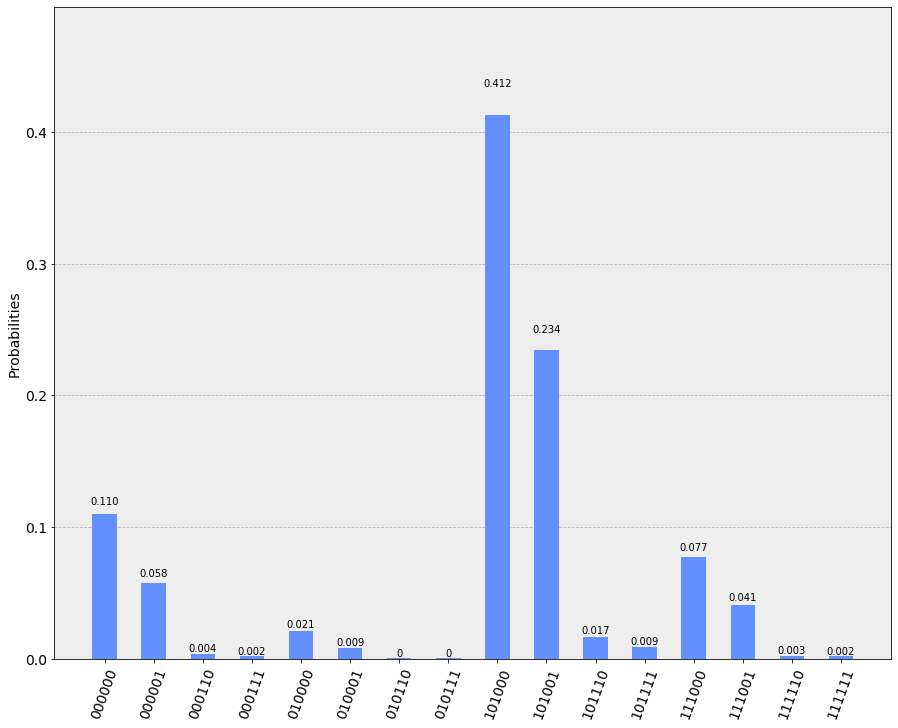

In [27]:
plot_histogram(cts, figsize = (15,12))

We can also take a look at the quantum circuit constructed to perform this round. We see quantum state preparation, followed by change of basis transformation. We see $q_2$ and $q_5$ don't undergo these transformations, as they are target qubits. We also see the two CNOT operations which produce the entanglement, and finally measurements.

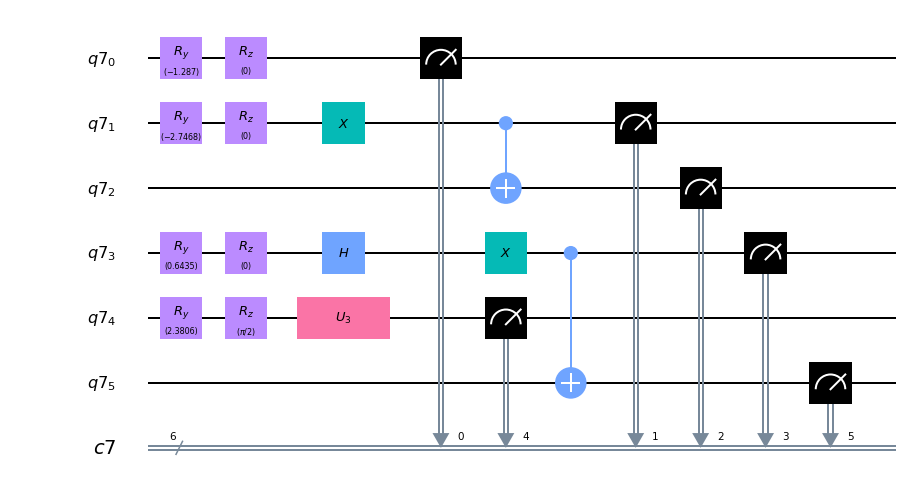

In [28]:
qc.draw(output = "mpl", scale = 1, interactive=True)

Qiskit also allows us to take a look at the Bloch sphere diagrams of the individual qubits. Here we show the Bloch sphere representation of the qubits right after state vector preparation and before the change of basis transformation. We see that qubits $q_2$ and $q_5$ are at $|0\rangle$ state, which is because the didn't go through any transformation as they target qubits for entanglement.

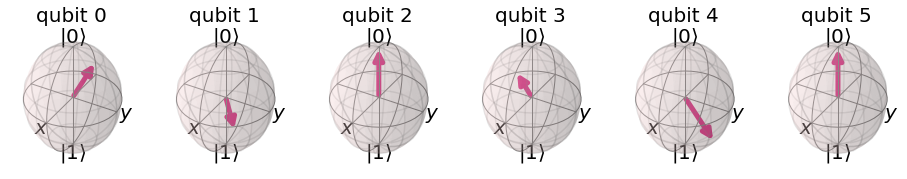

In [29]:
qiskit.visualization.plot_bloch_multivector(bloch.get_statevector())

## BlocQto - The Game 


### Initialization
These cells contain the necessary code to set up the game. Most of the code here are for quality of life improvements and do not contain much concepts or physics. Before each new game, we generate a new value for ```island_seed``` in the below cell. This seed determines the island-basis mapping. 



In [0]:
island_seed = random.randint(1,100)

We recommend you keep the below cells unchanged.

In [0]:
# Initialize the scoreboard
tab = pd.DataFrame(columns = ["Alice's Guess", "Bob's Guess",'Result','Control Islands', 
                              "Alice's Row", "Bob's Row","Alice's Score", "Bob's Score", 
                              "Alice's Total Score", "Bob's Total Score"])
# Initialize the island basis map
basis_list = ['Z', "Z'", 'X', "X'", 'Y', "Y'"]
scoreA = 0
scoreB = 0
sA = 0
sB = 0

def play_round(rowA, rowB, entanA, entanB, playlist, basis_list, scoreA, scoreB, qr, cr, qc):    

    # Fix a value for random seed. That would define the island basis mapping
    random.seed(island_seed)
    perm = permutations(basis_list) 
    perm = list(perm)
    basis = list(random.choice(perm))
    random.seed()
    # EntanList is of the form: [Island selected for entanglement by playerA, Island selected for entanglement by playerB]
    entan_controls = [entanA,entanB]
    # Random islands are selected here as target for entanglement
    rA = random.choice(list(range(6)))
    rB = random.choice(list(range(6)))
    while(rA == rB or rA in entan_controls or rB in entan_controls):
        rA = random.choice(list(range(6)))
        rB = random.choice(list(range(6)))
    ans, result, bloch, final_res = engine(playlist['Alice'][rowA], playlist['Bob'][rowB], basis, entan_controls, [rA,rB])
    # Updating cumulative scores
    scoreA += list(ans).count('0')
    scoreB += list(ans).count('1')
    # Updating current scores
    curr_scoreA = list(ans).count('0')
    curr_scoreB = list(ans).count('1')

    
    return(scoreA, scoreB, rowA, rowB, entanA, entanB, curr_scoreA, curr_scoreB, bloch, final_res)

In [0]:
"""
config_Alice: Configuration of Alice from the playlist table
config_Bob: Configuration of Bob from the playlist table
entan_Alice: Island of entanglement for Alice
entan_Bob: Island of entanglement for Bob
"""

def play_game(tab, playlist, basis_list, sA, sB, first_turn = 0, alice_entan_choices = [], bob_entan_choices = []):
    # lists to store already selected choices
    alice_row_choices = []
    bob_row_choices = []

    finish = 0
    if len(alice_entan_choices) < 3:

        while 1==1 :
            first_turn = input('\n Who wants to go first? \n\n Press 0 for Alice \n\n Press 1 for Bob\n')
            print('Enter "exit" to exit')
            if first_turn == 'exit':
                return
            else:
                first_turn = int(first_turn)
                break
    if len(alice_entan_choices) >= 3:
        first_turn = (first_turn + 1)%2
        display(tab)
    
    for i in range(3):
        if (i + first_turn)%2 == 0: 
            if len(alice_entan_choices) >= 3:
                print('\nRound {}\n'.format(i+4))
            else:
                print('\nRound {}\n'.format(i+1))
            print('Enter "exit" to exit')
            print('Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}')
            while 1 == 1:
                config_Alice = getpass.getpass(prompt = "Enter configuration row number for Alice: ")
                if config_Alice == 'exit':
                    print('exit command received')
                    return
                else:
                    config_Alice = int(config_Alice)
                    if config_Alice in alice_row_choices:
                        print ('Configuration already chosen. Please enter again')
                    else:
                        if config_Alice not in {0,1,2,3}:
                            print('Invalid choice. Please enter again')
                        else:
                            alice_row_choices.append(config_Alice)
                            break
            while 1 == 1:
                config_Bob = getpass.getpass(prompt = "Enter configuration row number for Bob: ")
                if config_Bob == 'exit':
                    print('exit command received')
                    return
                else:
                    config_Bob = int(config_Bob)
                    if config_Bob in bob_row_choices:
                        print ('Configuration already chosen. Please enter again')
                    else:
                        if config_Bob not in {0,1,2,3}:
                            print('Invalid choice. Please enter again')
                        else:
                            bob_row_choices.append(config_Bob)
                            break
            while 1 == 1:
                if tab.shape[0] < 5:
                    entan_Alice = input("Choose island for entanglement for Alice: ")
                    if entan_Alice == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Alice = int(entan_Alice)
                        if entan_Alice in alice_entan_choices:
                            print ('Island already chosen for entanglement. Please enter again')
                        else:
                            if entan_Alice not in {0,1,2,3,4,5}:
                                print('Invalid choice. Please enter again')
                            else:
                                alice_entan_choices.append(entan_Alice)
                                break
                else:
                    entan_Alice = input("Choose final island for entanglement for Alice: ")
                    if entan_Alice == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Alice = int(entan_Alice)
                        if entan_Alice not in {0,1,2,3,4,5}:
                            print('Invalid choice. Please enter again')
                        else:
                            alice_entan_choices.append(entan_Alice)
                            break
            while 1 == 1:
                if tab.shape[0] < 5:
                    entan_Bob = input("Choose island for entanglement for Bob: ")
                    if entan_Bob == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Bob = int(entan_Bob)
                        if entan_Bob in bob_entan_choices:
                            print ('Island already chosen for entanglement. Please enter again')
                        else:
                            if entan_Bob not in {0,1,2,3,4,5}:
                                print('Invalid choice. Please enter again')
                            elif entan_Bob == entan_Alice:
                                print('Island already chosen by Alice. Please choose another island')
                            else:
                                bob_entan_choices.append(entan_Bob)
                                break
                else:
                    entan_Bob = input("Choose final island for entanglement for Bob: ")
                    if entan_Bob == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Bob = int(entan_Bob)
                        if entan_Bob not in {0,1,2,3,4,5}:
                            print('Invalid choice. Please enter again')
                        elif entan_Bob == entan_Alice:
                            print('Island already chosen by Alice. Please choose another island')
                        else:
                            bob_entan_choices.append(entan_Bob)
                            break
        else:
            if len(alice_entan_choices) >= 3:
                print('\nRound {}\n'.format(i+4))
            else:
                print('\nRound {}\n'.format(i+1))

            print('Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}')
            while 1 == 1:
                config_Bob = getpass.getpass(prompt = "Enter configuration row number for Bob: ")
                if config_Bob == 'exit':
                    print('exit command received')
                    return
                else:
                    config_Bob = int(config_Bob)
                    if config_Bob in bob_row_choices:
                        print ('Configuration already chosen. Please enter again')
                    else:
                        if config_Bob not in {0,1,2,3}:
                            print('Invalid choice. Please enter again')
                        else:
                            bob_row_choices.append(config_Bob)
                            break
            while 1 == 1:
                config_Alice = getpass.getpass(prompt = "Enter configuration row number for Alice: ")
                if config_Alice == 'exit':
                    print('exit command received')
                    return
                else:
                    config_Alice = int(config_Alice)
                    if config_Alice in alice_row_choices:
                        print ('Configuration already chosen. Please enter again')
                    else:
                        if config_Alice not in {0,1,2,3}:
                            print('Invalid choice. Please enter again')
                        else:
                            alice_row_choices.append(config_Alice)
                            break
            while 1 == 1:
                if tab.shape[0] < 5:
                    entan_Bob = input("Choose island for entanglement for Bob: ")
                    if entan_Bob == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Bob = int(entan_Bob)
                        if entan_Bob in bob_entan_choices:
                            print ('Island already chosen for entanglement. Please enter again')
                        else:
                            if entan_Bob not in {0,1,2,3,4,5}:
                                print('Invalid choice. Please enter again')
                            else:
                                bob_entan_choices.append(entan_Bob)
                                break
                else:
                    entan_Bob = input("Choose final island for entanglement for Bob: ")
                    if entan_Bob == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Bob = int(entan_Bob)
                        if entan_Bob not in {0,1,2,3,4,5}:
                            print('Invalid choice. Please enter again')
                        else:
                            bob_entan_choices.append(entan_Bob)
                            break
            while 1 == 1:
                if tab.shape[0] < 5:
                    entan_Alice = input("Choose island for entanglement for Alice: ")
                    if entan_Alice == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Alice = int(entan_Alice)
                        if entan_Alice in alice_entan_choices:
                            print ('Island already chosen for entanglement. Please enter again')
                        else:
                            if entan_Alice not in {0,1,2,3,4,5}:
                                print('Invalid choice. Please enter again')
                            elif entan_Alice == entan_Bob:
                                print('Island already chosen by Bob. Please choose another island')
                            else:
                                alice_entan_choices.append(entan_Alice)
                                break
                else:
                    entan_Alice = input("Choose final island for entanglement for Alice: ")
                    if entan_Alice == 'exit':
                        print('exit command received')
                        return
                    else:
                        entan_Alice = int(entan_Alice)
                        if entan_Alice not in {0,1,2,3,4,5}:
                            print('Invalid choice. Please enter again')
                        elif entan_Alice == entan_Bob:
                            print('Island already chosen by Bob. Please choose another island')
                        else:
                            alice_entan_choices.append(entan_Alice)
                            break

        qr = QuantumRegister(6)
        cr = ClassicalRegister(6)
        qc = QuantumCircuit(qr, cr)
        # execute one round
        sA, sB, rowA, rowB, entanA, entanB, curr_scoreA, curr_scoreB, bloch, final_res = play_round(config_Alice, config_Bob, entan_Alice, entan_Bob, playlist, basis_list, sA, sB, qr, cr, qc)
        # Update the scoreboard
        print("\n Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]")
        tab = tab.append(pd.DataFrame([[playlist['Alice'][rowA], playlist['Bob'][rowB], final_res, [entanA,entanB], rowA, rowB, curr_scoreA, curr_scoreB, sA, sB]], 
                                      columns = ["Alice's Guess", "Bob's Guess",'Result', 'Control Islands', 
                                                 "Alice's Row", "Bob's Row", "Alice's Score", "Bob's Score","Alice's Total Score",
                                                "Bob's Total Score"]), 
                         ignore_index = True)
        print('\nScoreboard')
        display(tab)
        print('\nConfigurations')
        display(playlist)
        
        finish += 1
    if finish == 3:
        if tab.shape[0] == 6:
            random.seed(10)
            perm = permutations(basis_list) 
            perm = list(perm)
            basis = list(random.choice(perm))
            print('Island basis mapping for the game: {}'.format(basis))
            if tab["Alice's Total Score"].values[-1] > tab["Bob's Total Score"].values[-1]:
                print("\n Alice wins")
            elif tab["Alice's Total Score"].values[-1] < tab["Bob's Total Score"].values[-1]:
                print("\n Bob wins")
            else:
                print("\n The match has ended as a draw")
        else:
            print("\n Half Time")
    return tab, sA, sB, first_turn, alice_entan_choices, bob_entan_choices

In [0]:
def validity_check(playlist):
    flag1 = 0
    l = 0
    for x in playlist:
        p = 0
        for y in x:
            if sum([np.abs(k) for k in y]) != 60:
                print('Not all combinations are valid')
                if p == 0:
                    print("Check Alice's combination in row index {}. It does not sum to 60".format(l))
                else:
                    print("Check Bob's combination in row  index {}. It does not sum to 60".format(l))
                flag1 += 1
                break
            elif len(y) != 6:
                print('Not all combinations are valid')
                if p == 0:
                    print('Invalid length of configuration for Alice in row index {}. The length of the configurations should be exaclty 6'.format(l))
                else:
                    print('Invalid length of configuration for Bob in row index {}. The length of the configurations should be exaclty 6'.format(l))
                flag1 += 1
                break
            elif 0 in y:
                print('Not all combinations are valid')
                if p == 0:
                    print("0 encountered in Alice's configuration in row index {}".format(l))
                else:
                    print("0 encountered in Bob's configuration in row index {}".format(l))
                flag1 += 1
                break
            else:
                for z in y:
                    if np.imag(z) != 0 and np.real(z) != 0:
                        print('Not all combinations are valid')
                        if p == 0:
                            print("Invalid value encountered in Alice's configuration in row index {}. The values should be either real or imaginary.".format(l))
                        else:
                            print("Invalid value encountered in Bob's configuration in row index {}. The values should be either real or imaginary.".format(l))
                        flag1 += 1  
                        break
                p += 1
        if flag1 != 0:
            break
        else:
            l += 1

    if flag1 == 0:
        print('All configurations are valid')
        playlist = pd.DataFrame(playlist, columns = ['Alice', 'Bob'])
    return playlist

### Playing BlocQto
Note that the target islands for each round are never disclosed, they can only be deduced. So while reading the results, players must factor in the fact that, 
if an island has the same result as the results of the control islands, then it could (or not) be due to entanglement.
#### First Half
We're here! Let us begin the game. Enter configurations for the first half. The order being [Alice's configuration, Bob's configuration]. 

In [0]:
playlist1 = []
playlist1.append([[20, 1, -1, -30, -4, 4], [5, 5, 5, 5, 20, 20]])
playlist1.append([[2, -20, -9j, 20, 4, 5], [10, 10, 5, 15, 15j, 5]])
playlist1.append([[4, -4, 5, -5, -40, -2], [-15, 5, -10, 10, 10, -10]])
playlist1.append([[-2, -20j, 9j, 20, -4, 5], [-10, 10, -5, 15j, 15j, 5]])

In [35]:
playlist1 = validity_check(playlist1)

All configurations are valid


Run the below cell to play the first half.

In [36]:
tab, sA, sB, first_turn, alice_entan_choices, bob_entan_choices = play_game(tab, playlist1, basis_list, sA, sB)


 Who wants to go first? 

 Press 0 for Alice 

 Press 1 for Bob
0
Enter "exit" to exit

Round 1

Enter "exit" to exit
Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}
Enter configuration row number for Alice: ··········
Enter configuration row number for Bob: ··········
Choose island for entanglement for Alice: 1
Choose island for entanglement for Bob: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


0  ::  1
1  ::  1
2  ::  1
3  ::  1
4  ::  1
5  ::  0

 Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]

Scoreboard


,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5



Configurations


,Alice,Bob
0,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]"
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]"
2,"[4, -4, 5, -5, -40, -2]","[-15, 5, -10, 10, 10, -10]"
3,"[-2, (-0-20j), 9j, 20, -4, 5]","[-10, 10, -5, 15j, 15j, 5]"



Round 2

Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}
Enter configuration row number for Bob: ··········
Configuration already chosen. Please enter again
Enter configuration row number for Bob: ··········
Enter configuration row number for Alice: ··········
Invalid choice. Please enter again
Enter configuration row number for Alice: ··········
Choose island for entanglement for Bob: 2
Choose island for entanglement for Alice: 4
0  ::  0
1  ::  0
2  ::  1
3  ::  0
4  ::  1
5  ::  0

 Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]

Scoreboard


,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]","[0, 0, 1, 0, 1, 0]","[4, 2]",1,1,4,2,5,7



Configurations


,Alice,Bob
0,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]"
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]"
2,"[4, -4, 5, -5, -40, -2]","[-15, 5, -10, 10, 10, -10]"
3,"[-2, (-0-20j), 9j, 20, -4, 5]","[-10, 10, -5, 15j, 15j, 5]"



Round 3

Enter "exit" to exit
Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}
Enter configuration row number for Alice: ··········
Enter configuration row number for Bob: ··········
Configuration already chosen. Please enter again
Enter configuration row number for Bob: ··········
Configuration already chosen. Please enter again
Enter configuration row number for Bob: ··········
Choose island for entanglement for Alice: 5
Choose island for entanglement for Bob: 1
0  ::  1
1  ::  0
2  ::  0
3  ::  1
4  ::  1
5  ::  0

 Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]

Scoreboard


,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]","[0, 0, 1, 0, 1, 0]","[4, 2]",1,1,4,2,5,7
2,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]","[1, 0, 0, 1, 1, 0]","[5, 1]",0,0,3,3,8,10



Configurations


,Alice,Bob
0,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]"
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]"
2,"[4, -4, 5, -5, -40, -2]","[-15, 5, -10, 10, 10, -10]"
3,"[-2, (-0-20j), 9j, 20, -4, 5]","[-10, 10, -5, 15j, 15j, 5]"



 Half Time


Enter configuration for second half. 

In [0]:
playlist2= []
playlist2.append([[10, 1, -1, -40, -4, 4], [2, 8, 5, -5, 15, 25]])
playlist2.append([[2, -20, -9j, 20j, 7, 2], [10, -10, 5, 15, 15j, 5]])
playlist2.append([[4, -4j, 8, -2, -30, -12], [-15j, 8, 7, 10, -10j, -10]])
playlist2.append([[-2j, -40j, 9j, 1, -4, 4], [-10, 8, -7, 15j, -15, 5]])

In [38]:
playlist2 = validity_check(playlist2)

All configurations are valid


Run the below cell to play the second half.

In [39]:
tab1, sA1, sB1 , first_turn1, alice_entan_choices1, bob_entan_choices1 = play_game(tab, playlist2, basis_list, sA, sB, first_turn, alice_entan_choices, bob_entan_choices)

,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]","[0, 0, 1, 0, 1, 0]","[4, 2]",1,1,4,2,5,7
2,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]","[1, 0, 0, 1, 1, 0]","[5, 1]",0,0,3,3,8,10



Round 4

Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}
Enter configuration row number for Bob: ··········
Enter configuration row number for Alice: ··········
Choose island for entanglement for Bob: 3
Choose island for entanglement for Alice: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


0  ::  1
1  ::  0
2  ::  1
3  ::  0
4  ::  1
5  ::  1

 Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]

Scoreboard


,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]","[0, 0, 1, 0, 1, 0]","[4, 2]",1,1,4,2,5,7
2,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]","[1, 0, 0, 1, 1, 0]","[5, 1]",0,0,3,3,8,10
3,"[4, (-0-4j), 8, -2, -30, -12]","[10, -10, 5, 15, 15j, 5]","[1, 0, 1, 0, 1, 1]","[0, 3]",2,1,2,4,10,14



Configurations


,Alice,Bob
0,"[10, 1, -1, -40, -4, 4]","[2, 8, 5, -5, 15, 25]"
1,"[2, -20, (-0-9j), 20j, 7, 2]","[10, -10, 5, 15, 15j, 5]"
2,"[4, (-0-4j), 8, -2, -30, -12]","[(-0-15j), 8, 7, 10, (-0-10j), -10]"
3,"[(-0-2j), (-0-40j), 9j, 1, -4, 4]","[-10, 8, -7, 15j, -15, 5]"



Round 5

Enter "exit" to exit
Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}
Enter configuration row number for Alice: ··········
Configuration already chosen. Please enter again
Enter configuration row number for Alice: ··········
Enter configuration row number for Bob: ··········
Choose island for entanglement for Alice: 2
Choose island for entanglement for Bob: 4
0  ::  1
1  ::  1
2  ::  1
3  ::  0
4  ::  0
5  ::  1

 Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]

Scoreboard


,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]","[0, 0, 1, 0, 1, 0]","[4, 2]",1,1,4,2,5,7
2,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]","[1, 0, 0, 1, 1, 0]","[5, 1]",0,0,3,3,8,10
3,"[4, (-0-4j), 8, -2, -30, -12]","[10, -10, 5, 15, 15j, 5]","[1, 0, 1, 0, 1, 1]","[0, 3]",2,1,2,4,10,14
4,"[(-0-2j), (-0-40j), 9j, 1, -4, 4]","[-10, 8, -7, 15j, -15, 5]","[1, 1, 1, 0, 0, 1]","[2, 4]",3,3,2,4,12,18



Configurations


,Alice,Bob
0,"[10, 1, -1, -40, -4, 4]","[2, 8, 5, -5, 15, 25]"
1,"[2, -20, (-0-9j), 20j, 7, 2]","[10, -10, 5, 15, 15j, 5]"
2,"[4, (-0-4j), 8, -2, -30, -12]","[(-0-15j), 8, 7, 10, (-0-10j), -10]"
3,"[(-0-2j), (-0-40j), 9j, 1, -4, 4]","[-10, 8, -7, 15j, -15, 5]"



Round 6

Note that configurations or row numbers should be chosesn from {0,1,2,3} and entanglement choice should be chosen from {0,1,2,3,4,5}
Enter configuration row number for Bob: ··········
Enter configuration row number for Alice: ··········
Choose final island for entanglement for Bob: 5
Choose final island for entanglement for Alice: 3
0  ::  1
1  ::  1
2  ::  0
3  ::  0
4  ::  0
5  ::  1

 Note that the 'Control Islands' values should be read as [Alice's Island, Bob's Island]

Scoreboard


,Alice's Guess,Bob's Guess,Result,Control Islands,Alice's Row,Bob's Row,Alice's Score,Bob's Score,Alice's Total Score,Bob's Total Score
0,"[-2, (-0-20j), 9j, 20, -4, 5]","[-15, 5, -10, 10, 10, -10]","[1, 1, 1, 1, 1, 0]","[1, 0]",3,2,1,5,1,5
1,"[2, -20, (-0-9j), 20, 4, 5]","[10, 10, 5, 15, 15j, 5]","[0, 0, 1, 0, 1, 0]","[4, 2]",1,1,4,2,5,7
2,"[20, 1, -1, -30, -4, 4]","[5, 5, 5, 5, 20, 20]","[1, 0, 0, 1, 1, 0]","[5, 1]",0,0,3,3,8,10
3,"[4, (-0-4j), 8, -2, -30, -12]","[10, -10, 5, 15, 15j, 5]","[1, 0, 1, 0, 1, 1]","[0, 3]",2,1,2,4,10,14
4,"[(-0-2j), (-0-40j), 9j, 1, -4, 4]","[-10, 8, -7, 15j, -15, 5]","[1, 1, 1, 0, 0, 1]","[2, 4]",3,3,2,4,12,18
5,"[2, -20, (-0-9j), 20j, 7, 2]","[2, 8, 5, -5, 15, 25]","[1, 1, 0, 0, 0, 1]","[3, 5]",1,0,3,3,15,21



Configurations


,Alice,Bob
0,"[10, 1, -1, -40, -4, 4]","[2, 8, 5, -5, 15, 25]"
1,"[2, -20, (-0-9j), 20j, 7, 2]","[10, -10, 5, 15, 15j, 5]"
2,"[4, (-0-4j), 8, -2, -30, -12]","[(-0-15j), 8, 7, 10, (-0-10j), -10]"
3,"[(-0-2j), (-0-40j), 9j, 1, -4, 4]","[-10, 8, -7, 15j, -15, 5]"


Island basis mapping for the game: ['Y', "Y'", "Z'", 'X', "X'", 'Z']

 Bob wins
